In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 04: Seleção de modelo e hiperparametros

**1.** O código abaixo carrega o banco de dados *California housing*. Divida o banco de dados em treino, teste e validação. Use o conjunto de validação para escolher o coeficiente de regularização $c$ para um modelo de regressão linear com penalização $L_2$. Use a fórmula analítica para estimar os pesos do modelo de regressão. Plote os MSE no conjunto de trieno e validação em função de $c$. Comente o resultado. Avalie a performance do modelo ótimo no conjunto de teste e também comente.

In [19]:
SEED = 42
np.random.seed(SEED)

X, y = fetch_california_housing(return_X_y=True)

Vamos iniciar dividindo o banco de dados em treino, teste e validação, e montaremos a classe LinearRegression utilizando a forma analítica para a regressão linear com penalização $L_2$.

In [3]:
# splitting in train, test and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

# linear regression with L2 penalty
class LinearRegression:
    def __init__(self, c=0.0):
        self.c = c
        self.w = None
        self.ws = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        X = np.concatenate((np.ones((n_samples, 1)), X), axis=1)
        self.w = np.linalg.inv(X.T.dot(X) + self.c * np.eye(n_features + 1)).dot(X.T).dot(y)
        self.ws.append(self.w)
    
        
    def predict(self, X):
        n_samples, _ = X.shape
        X = np.concatenate((np.ones((n_samples, 1)), X), axis=1)
        return X.dot(self.w)

Agora plotaremos os MSEs para vários valores de $c$ no conjunto de treino:

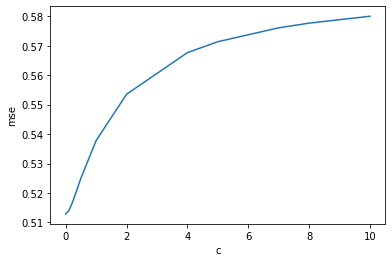

[0.5129053351430599,
 0.5139391663484985,
 0.5162297771707892,
 0.5190492455161713,
 0.5250098646237105,
 0.5378016026119727,
 0.5535211569475829,
 0.567648751682183,
 0.5713523547514842,
 0.5760669380179653,
 0.5776589761566825,
 0.5799936458116461]

In [23]:
c_values = [0, 0.1, 0.2, 0.3, 0.5, 1.0, 2, 4, 5, 7, 8, 10]

# train model for different values of c
mse_train = []

for c in c_values:
    model = LinearRegression(c=c)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    # compute mse
    mse_train.append(np.mean((y_pred - y_train) ** 2))

# plot
plt.plot(c_values, mse_train)
plt.xlabel('c')
plt.ylabel('mse')
plt.show()
mse_train

Observe que conforme aumentamos o $c$, o MSE aumenta, indicando que não utilizar o $c$ (isto é, $c=0$) é a melhor escolha. Abaixo fazemos uma checagem rápida para verificar se a norma dos pesos está diminuindo conforme aumentamos o valor de $c$:

In [14]:
# checking if norm of weights is decreasing as c increases
weight_norms = []
for c in c_values:
    model = LinearRegression(c=c)
    model.fit(X_train, y_train)
    weight_norms.append(np.linalg.norm(model.w))
print(weight_norms)

[32.38811355980463, 29.04385751907649, 26.326739876803508, 22.18004933164637, 15.923996287396049, 10.206098421273795, 5.993625985634436, 4.993637675699369, 3.780934710181593, 3.38825042881348, 2.8309751937456094]


De fato ela está, indicando que o processo é correto. Fazemos a plotagem dos MSEs para o conjunto de validação:

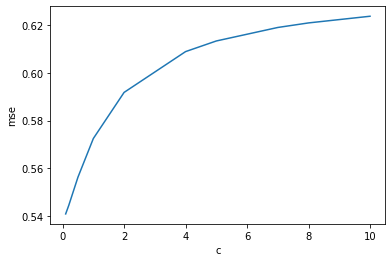

In [15]:
# validation
mse_validation = []

for c in c_values:
    model = LinearRegression(c=c)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    # compute mse
    mse_validation.append(np.mean((y_pred - y_val) ** 2))

# plot
plt.plot(c_values, mse_validation)
plt.xlabel('c')
plt.ylabel('mse')
plt.show()

Obtivemos resultado semelhante: nesse caso, não utilizar penaties é melhor. Por fim, fazemos o cálculo do MSE para o melhor valor de $c$ no conjunto de teste:

In [17]:
# test
model = LinearRegression(c=0.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse_test = np.mean((y_pred - y_test) ** 2)
print(mse_test)

0.5544725485140232


O erro é baixo, e nos mostra que, de fato, utilizar $c=0$ é uma boa escolha. Essa questão pode ser justificada pelo fato de que temos um banco de dados muito grande, em que não há ganho em queda de variância, e estamos aumentando o viés sem trazer benefícios, então aumentar o $c$ não é uma boa escolha.

**2.** Implemente 5-fold *nested cross validation* para escolher entre os métodos $k$-NN e regressão linear com regularização $L_2$ (similar ao exercício acima). Considere $k \in \{1, 2, 3, 4, 5\}$ e $c \in \{0, 1, 10, 100\}$. Use o mesmo banco de dados do último exercício e comente o resultado. Em média, qual valor de hiperparametro resulta na melhor performance para o método escolhido?

Obs.: para simplificar sua vida, use o $k$-NN para regressão do scikit-learning com distância euclidiana.

Faremos abaixo a implementação de uma função que implementa os métodos $k$-NN e regressão linear com regularização $L_2$ para cada $k$ e $c$ indicado e retorna os MSEs:

In [237]:
# get knn from sklearn
from sklearn.neighbors import KNeighborsRegressor

# pre defined values
c = 1
k = 1
cs = [0, 1, 10, 100]
ks = [1, 2, 3, 4, 5]
models = [KNeighborsRegressor(n_neighbors=k, weights='distance'), LinearRegression(c=c)]

# function to check the performance of the models
def check_method(X_train, y_train, X_test, y_test, linear_mse, knn_mse):
    models = ['linear', 'knn']

    for model in models:
        # linear regression
        if model == 'linear':
            for i, c in enumerate(cs):
                model = LinearRegression(c=c)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                # compute mse
                mse = np.mean((y_pred - y_test) ** 2)
                linear_mse[i]+=mse

        # knn  
        else:
            for i, k in enumerate(ks):
                model = KNeighborsRegressor(n_neighbors=k)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                # compute mse
                mse = np.mean((y_pred - y_test) ** 2)
                knn_mse[i]+=mse

    return linear_mse, knn_mse

Agora implementamos o 5-fold *nested cross validation*, e utilizamos a função acima para calcular os MSEs para cada $k$ e $c$:

In [236]:
# nested cross validation to get the best model and its parameters

indexes = [0, int(X.shape[0]/5) , int(2* X.shape[0]/5), int(3*X.shape[0]/5), int(4*X.shape[0]/5), int(X.shape[0])]
count = 0

linear_mse = [0, 0, 0, 0]
knn_mse = [0, 0, 0, 0, 0]

for i in indexes:
    if i == int(X.shape[0]):
        break
    i_2 = indexes[count+1]

    # split data in train and test
    X_test = X[i:i_2]
    y_test = y[i:i_2]
    X_train = np.concatenate((X[:i], X[i_2:]))
    y_train = np.concatenate((y[:i], y[i_2:]))
    count += 1
    
    # split train in validation and train
    indexes_2 = [0, int(X_train.shape[0]/5) , int(2* X_train.shape[0]/5), int(3*X_train.shape[0]/5), int(4*X_train.shape[0]/5), int(X_train.shape[0])]
    count_2 = 0
    for j in indexes_2:
        if j == int(X_train.shape[0]):
            break
        j_2 = indexes_2[count_2+1]

        # split data
        X_val = X_train[j:j_2]
        y_val = y_train[j:j_2]
        X_train_2 = np.concatenate((X_train[:j], X_train[j_2:]))
        y_train_2 = np.concatenate((y_train[:j], y_train[j_2:]))
        count_2 += 1

        # check the performance of the models
        linear_mse, knn_mse = check_method(X_train_2, y_train_2, X_val, y_val, linear_mse, knn_mse)

Por fim, escolhemos o melhor método e o melhor valor de hiperparâmetro para cada método, calculando os MSEs médios e escolhendo o menor:

In [239]:
# get mean of mse
linear_mse = [mse/5 for mse in linear_mse]
knn_mse = [mse/5 for mse in knn_mse]

# concatenate mse
mse = linear_mse + knn_mse

# get best parameter
best_parameter = None
best_mse = None

for i, mse in enumerate(mse):
    if best_mse is None or mse < best_mse:
        best_mse = mse
        if i < 4:
            best_parameter = cs[i]
            best_method = 'Linear Regression'
        else:
            best_parameter = ks[i-4]
            best_method = 'kNN'

print('The best method is', best_method, 'with parameter', best_parameter)

The best method is Linear Regression with parameter 0


Obtivemos que o melhor método é o da Regressão Linear, utilizando parâmetro $c=0$, conforme esperado, já que havíamos obtido esse resultado no exercício anterior (de que para a regressão linear com penalização $L_2$ nesse banco de dados, o melhor valor de $c$ é $0$).

# Exercício de "papel e caneta"

**1.** Nas nota de aula, derivamos o "dilema viés-variância" calculando o MSE esperado entre a função alvo de aprendizado $f$ e a predição do nosos modelo $h_{\mathcal{D}}$:

$$
\mathbb{E}_{x, \mathcal{D}} 
    \left[ 
        \left( 
        h_{\mathcal{D}}(x) - f\left(x\right) 
        \right)^2
    \right] =
\mathbb{E}_{x}[\underbrace{\textrm{Var}_{\mathcal{D}}[
        h_{\mathcal{D}}(x)]}_{\text{ Variância} }] + \mathbb{E}_{x} [ (\underbrace{\mathbb{E}_{\mathcal{D}}[
        h_{\mathcal{D}}(x) - f\left(x\right)]  }_{\text{Viés}})^2] 
    ].
$$

Com isso em mente, adapte nossa derivação para o caso em que as respostas de teste $f(x)$ são corrompidas por um ruído aditivo aleatório $\epsilon$ com média zero, i.e., ovbservamos $f^\prime(x) = f(x) + \epsilon$. Mais concretamente, trabalhe a seguinte esperança para derivar uma decomposição similar à da nota de aula:
$$
\mathbb{E}_{x, \epsilon, \mathcal{D}} 
    \left[
        \left( 
        h_{\mathcal{D}}(x) - f^\prime\left(x\right).
        \right)^2
    \right] 
$$

Compare a diferença entre a decomposição que você obteve e a da nota de aula.

Dica: sua decomposição deve se diferenciar da acima em apenas um termo aditivo, que envolve uma esperança sobre $x$ e $y$.

**Resposta:**

Partiremos da seguinte esperança:
$$\mathbb{E}_{x, \epsilon, \mathcal{D}} [\left(h_{\mathcal{D}}(x) - f^\prime\left(x\right)\right)^2]=$$
$$\mathbb{E}_{x, \epsilon, \mathcal{D}} [\left(h_{\mathcal{D}}(x) - (f\left(x\right)+ \epsilon) \right)^2]=$$
$$\mathbb{E}_{x, \epsilon, \mathcal{D}} [h_{\mathcal{D}}(x)^2 - 2 h_{\mathcal{D}}(x)(f\left(x\right)+\epsilon) + (f\left(x\right)+\epsilon)^2]$$

Queremos completar quadrados, então somaremos $\mathbb{E}_{x, \epsilon}[ \mathbb{E}_{\mathcal{D}}[ h_{\mathcal{D}} (x) ]^2 ] - \mathbb{E}_{x, \epsilon}[ \mathbb{E}_{\mathcal{D}}[ h_{\mathcal{D}} (x) ]^2 ] $ dos dois lados e teremos:

$$\mathbb{E}_{x, \epsilon, \mathcal{D}}[  h_{\mathcal{D}} (x)^2 -  2 h_{\mathcal{D}} (x)(f(x)+ \epsilon) +(f(x)+ \epsilon)^2 ] 
+ \mathbb{E}_{x, \epsilon}[ \mathbb{E}_{\mathcal{D}}[  h_{\mathcal{D}} (x) ]^2  ] - \mathbb{E}_{x, \epsilon}[ \mathbb{E}_{\mathcal{D}}[ h_{\mathcal{D}} (x) ]^2 ] = $$

$$\mathbb{E}_{x, \epsilon} [\mathbb{E}_{ \mathcal{D}} [  h_{\mathcal{D}} (x)^2 ] - \mathbb{E}_{\mathcal{D}} [h_{\mathcal{D}} (x) ]^2  ]  + \mathbb{E}_{x, \epsilon}[ \mathbb{E}_{\mathcal{D}}[  h_{\mathcal{D}} (x) ]^2  -2  \mathbb{E}_{\mathcal{D}} [h_{\mathcal{D}} (x) ( f(x)+\epsilon)] + ( f(x)+\epsilon)^2 ] = $$

Aqui reconhecemos a variância $\mathbb{E}_{x, \epsilon} [\mathbb{E}_{ \mathcal{D}} [  h_{\mathcal{D}} (x)^2 ] - \mathbb{E}_{\mathcal{D}} [h_{\mathcal{D}} (x) ]^2  ]$

$$ \mathbb{E}_{x}[ var_{ \mathcal{D}} [  h_{\mathcal{D}}(x)] ] + \mathbb{E}_{x, \epsilon}[ \mathbb{E}_{\mathcal{D}}[  h_{\mathcal{D}} (x) ]^2  -2  \mathbb{E}_{\mathcal{D}} [h_{\mathcal{D}} (x) ( f(x)+\epsilon)] + ( f(x)+\epsilon)^2 ] =$$
$$ \mathbb{E}_{x}[ var_{ \mathcal{D}} [  h_{\mathcal{D}}(x)]]  + \mathbb{E}_{x, \epsilon}[ \mathbb{E}_{\mathcal{D}}[  h_{\mathcal{D}} (x) ]^2  -2  \mathbb{E}_{\mathcal{D}} [h_{\mathcal{D}} (x) f(x)+ h_{\mathcal{D}} (x)\epsilon)] + f(x)^2 +2f(x)\epsilon +\epsilon^2 ] =$$

$$ \mathbb{E}_{x}[ var_{ \mathcal{D}} [  h_{\mathcal{D}}(x)]]  + \mathbb{E}_{x, \epsilon}[ \mathbb{E}_{\mathcal{D}}[  h_{\mathcal{D}} (x) ]^2  -2  \mathbb{E}_{\mathcal{D}} [h_{\mathcal{D}} (x) f(x)] -2\mathbb{E}_{\mathcal{D}} [ h_{\mathcal{D}} (x)\epsilon)] + f(x)^2 +2f(x)\epsilon +\epsilon^2 ] =$$

$$ \mathbb{E}_{x}[ var_{ \mathcal{D}} [  h_{\mathcal{D}}(x)]]   + \mathbb{E}_{x, \epsilon}[ (\mathbb{E}_{\mathcal{D}}[  h_{\mathcal{D}} (x) ]- f(x))^2]
+ \mathbb{E}_{x, \epsilon, \mathcal{D}}[2 f(x) \epsilon- 2 h_{\mathcal{D}}(x) \epsilon +\epsilon^2 ] =$$

Note que a equação está tomando um formato semelhante ao que conhecemos!

$$ \mathbb{E}_{x}[ var_{ \mathcal{D}} [  h_{\mathcal{D}}(x)]]   + \mathbb{E}_{x}[ (\mathbb{E}_{\mathcal{D}}[  h_{\mathcal{D}} (x) ]- f(x))^2]
+ \mathbb{E}_{x, \mathcal{D}}[2 f(x)\mathbb{E}_{\epsilon} \epsilon- 2 h_{\mathcal{D}}(x)\mathbb{E}_{\epsilon}  [\epsilon] +\mathbb{E}_{\epsilon} [\epsilon^2] ] =$$

Como os ruídos tem média zero, $\mathbb{E}_{\epsilon} [\epsilon] = 0$, então:

$$ \mathbb{E}_{x}[ var_{ \mathcal{D}} [  h_{\mathcal{D}}(x)]]   + \mathbb{E}_{x}[ (\mathbb{E}_{\mathcal{D}}[  h_{\mathcal{D}} (x) ]- f(x))^2]
+ \mathbb{E}_{x, \mathcal{D}}[\mathbb{E}_{\epsilon} [\epsilon^2] ] =$$
$$ \mathbb{E}_{x}[ var_{ \mathcal{D}} [  h_{\mathcal{D}}(x)]]   + \mathbb{E}_{x}[ (\mathbb{E}_{\mathcal{D}}[  h_{\mathcal{D}} (x) ]- f(x))^2]
+ var_{\epsilon}(\epsilon)$$

Na prática, obtivemos a mesma expressão, mas adicionamos a variância do ruído $\epsilon$.
